# Exercise 8: Training Neural Networks with Keras

In [1]:
# Load packages we need
import sys
import os
import datetime

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# we'll use keras for neural networks
import tensorflow.keras as keras
from tensorflow.keras.datasets import fashion_mnist

# import layers we will use
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate, Dropout

# import callbacks we will use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Load the TensorBoard notebook extension
%load_ext tensorboard

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots

### Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
### Numpy version: 1.19.5
### Scikit-learn version: 0.23.1
### Tensorflow version: 2.4.0
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.

seed = 42 # deterministic seed
np.random.seed(seed) 
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

## Let's use Fashion MNIST

In [3]:
def load_preprocess_fashion_mnist(minmax_normalize=True):
    
    labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    train, testval = fashion_mnist.load_data()
    
    train_x, train_y = train
    testval_x, testval_y = testval
    
    if minmax_normalize:
        train_x = train_x / 255.0
        testval_x = testval_x / 255.0
    
    # split test - val
    nval = testval_x.shape[0] // 2
    
    val_x = testval_x[:nval]
    val_y = testval_y[:nval]
    
    test_x = testval_x[nval:]
    test_y = testval_y[nval:]
    
    return train_x, train_y, test_x, test_y, val_x, val_y, np.array(labels)

In [4]:
train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_fashion_mnist()

### What does the data look like?

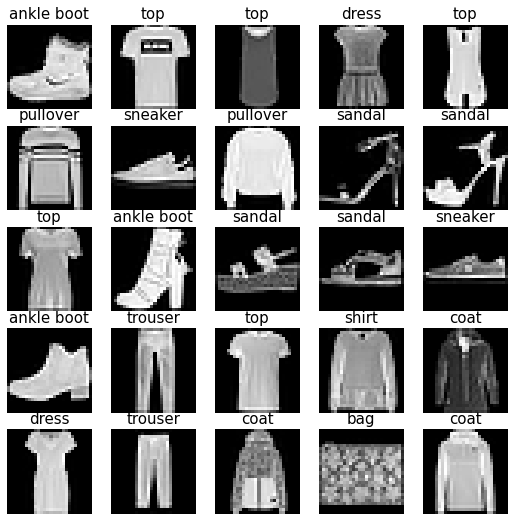

In [5]:
num_images = 25
label_idx = train_y[:num_images].astype(int)
titles = labels[label_idx]
plots.plot_images(train_x[:num_images].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(9,9), titles=titles)

In [6]:
train_x.shape

(60000, 28, 28)

In [7]:
train_y[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [8]:
def create_model_functional(input_shape=(28, 28)):  
    
    # let's use the functional API to create a model
    input_layer = Input(shape=input_shape, name='Input')

    flatten_layer = Flatten(name='Flatten')(input_layer)
    fc1 = Dense(300, name='FC1', activation='relu')(flatten_layer)
    fc2 = Dense(100, name='FC2', activation='relu')(fc1)
    
    output_layer = Dense(10, name='Output', activation='softmax')(fc2)
    
    model = keras.Model(name='FC-model', inputs=[input_layer], outputs=[output_layer])
    
    return model

In [9]:
model = create_model_functional()

In [10]:
# what does the model look like?
model.summary()

Model: "FC-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
Flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 300)               235500    
_________________________________________________________________
FC2 (Dense)                  (None, 100)               30100     
_________________________________________________________________
Output (Dense)               (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
# FC1.W.shape = 784*300; FC1.b.shape = 300*1
784*300 + 300

235500

### We can examine the layers of the model

In [12]:
model.layers

In [13]:
# we can also query specific layers by name and get their weights
fc1 = model.get_layer('FC1')

weights, biases = fc1.get_weights()

In [14]:
print(biases[:10])
print(weights[10,:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.06684147 -0.01177405  0.00687241  0.02096146  0.01017417 -0.03078672
 -0.02651066 -0.04857958 -0.02580751  0.06819397]


## Let's compile and train the model

In [15]:
# compile the model
# All the parameters in the compile function could be actual functions.
# For example:
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# set up an early stopping callback
early_stop_cb = EarlyStopping(monitor='val_accuracy', patience=3)

# set up a model checkpointing callback
fp = "./mymodel-bestweights.h5"
checkpoint_cb = ModelCheckpoint(fp, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

max_epochs = 100
batch_size = 64
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                     shuffle=True, callbacks=[early_stop_cb, checkpoint_cb])

Epoch 1/100
938/938 [==============================] - 3s 3ms/step - loss: 0.6382 - accuracy: 0.7800 - val_loss: 0.4386 - val_accuracy: 0.8394

Epoch 00001: val_accuracy improved from -inf to 0.83940, saving model to ./mymodel-bestweights.h5
Epoch 2/100
938/938 [==============================] - 2s 2ms/step - loss: 0.3632 - accuracy: 0.8666 - val_loss: 0.4587 - val_accuracy: 0.8398

Epoch 00002: val_accuracy improved from 0.83940 to 0.83980, saving model to ./mymodel-bestweights.h5
Epoch 3/100
938/938 [==============================] - 2s 2ms/step - loss: 0.3358 - accuracy: 0.8773 - val_loss: 0.3617 - val_accuracy: 0.8654

Epoch 00003: val_accuracy improved from 0.83980 to 0.86540, saving model to ./mymodel-bestweights.h5
Epoch 4/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2992 - accuracy: 0.8899 - val_loss: 0.3635 - val_accuracy: 0.8714

Epoch 00004: val_accuracy improved from 0.86540 to 0.87140, saving model to ./mymodel-bestweights.h5
Epoch 5/100
938/938 [==

### Load the model

In [17]:
loaded_model = tf.keras.models.load_model(fp)

In [18]:
# is it different from the previous model?
model, loaded_model

(<tensorflow.python.keras.engine.functional.Functional at 0x7fbfdd15da90>,
 <tensorflow.python.keras.engine.functional.Functional at 0x7fbfdccaff40>)

In [19]:
loss, acc = model.evaluate(test_x, test_y, verbose=0)
print('[Model] Test accuracy: {:.2f}%'.format(100*acc))

loss, acc = loaded_model.evaluate(test_x, test_y, verbose=0)
print('[Loaded Model] Test accuracy: {:.2f}%'.format(100*acc))

[Model] Test accuracy: 89.52%
[Loaded Model] Test accuracy: 89.60%


### We can (of course) save the model directly (i.e., without checkpointing)

In [20]:
model.save('mymodel.h5')

### Skip some layers with concatenation

In [21]:
def create_model_skip(input_shape=(28, 28)):  
    
    # let's use the functional API to create a model
    input_layer = Input(shape=input_shape, name='Input')
    flatten_layer = Flatten(name='Flatten')(input_layer)
    fc1 = Dense(324, activation='relu', name='FC1')(flatten_layer)
    fc2 = Dense(128, activation='relu', name='FC2')(fc1)
    dropout1 = Dropout(0.5, name='Dropout')(fc2)
    
    # let's concatenate the input (flattened) to the output of fc2
    concat_layer = Concatenate(name='Concat')([dropout1, flatten_layer]) 
    output_layer = Dense(10, activation='softmax', name='Output')(concat_layer)
    
    model = keras.Model(name='FC-model-with-skip', inputs=[input_layer], outputs=[output_layer])
    
    return model

In [22]:
model = create_model_skip()
model.summary()

Model: "FC-model-with-skip"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
Flatten (Flatten)               (None, 784)          0           Input[0][0]                      
__________________________________________________________________________________________________
FC1 (Dense)                     (None, 324)          254340      Flatten[0][0]                    
__________________________________________________________________________________________________
FC2 (Dense)                     (None, 128)          41600       FC1[0][0]                        
_________________________________________________________________________________

In [23]:
# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

early_stop_cb = EarlyStopping(monitor='val_loss', patience=5)

max_epochs = 100
batch_size = 128
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                     shuffle=True, callbacks=[early_stop_cb])

Epoch 1/100
469/469 [==============================] - 2s 3ms/step - loss: 0.7782 - accuracy: 0.7307 - val_loss: 0.4302 - val_accuracy: 0.8458
Epoch 2/100
469/469 [==============================] - 1s 3ms/step - loss: 0.4021 - accuracy: 0.8540 - val_loss: 0.4072 - val_accuracy: 0.8472
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.86 - 1s 3ms/step - loss: 0.3661 - accuracy: 0.8660 - val_loss: 0.3725 - val_accuracy: 0.8660
Epoch 4/100
469/469 [==============================] - 1s 3ms/step - loss: 0.3396 - accuracy: 0.8770 - val_loss: 0.3581 - val_accuracy: 0.8740
Epoch 5/100
469/469 [==============================] - 1s 3ms/step - loss: 0.3174 - accuracy: 0.8840 - val_loss: 0.3638 - val_accuracy: 0.8666
Epoch 6/100
469/469 [==============================] - 2s 3ms/step - loss: 0.3029 - accuracy: 0.8879 - val_loss: 0.3380 - val_accuracy: 0.8782
Epoch 7/100
469/469 [==============================] - 1s 3ms/step - loss: 0.2825 - accuracy: 0.8947

In [24]:
# create and compile model
model = create_model_skip()
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


# set up tensorboard log directory and callback
log_dir = './logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

# let's write some of the images data to logs
new_log_dir = './logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
fw = tf.summary.create_file_writer(new_log_dir)
with fw.as_default():
    for step in range(1, 11):
        tf.summary.image('train_images_{}'.format(step), train_x[(step-1)].reshape(-1, 28, 28, 1), step=step)
        

max_epochs = 50
batch_size = 128
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                     shuffle=True, callbacks=[tensorboard_cb])

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 0.7652 - accuracy: 0.7326 - val_loss: 0.4356 - val_accuracy: 0.8446
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.4076 - accuracy: 0.8513 - val_loss: 0.4123 - val_accuracy: 0.8462
Epoch 3/50
469/469 [==============================] - 2s 3ms/step - loss: 0.3659 - accuracy: 0.8663 - val_loss: 0.3685 - val_accuracy: 0.8680
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3358 - accuracy: 0.8783 - val_loss: 0.3562 - val_accuracy: 0.8676
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3141 - accuracy: 0.8833 - val_loss: 0.3617 - val_accuracy: 0.8654
Epoch 6/50
469/469 [==============================] - 2s 3ms/step - loss: 0.3005 - accuracy: 0.8876 - val_loss: 0.3445 - val_accuracy: 0.8706
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2818 - accuracy: 0.8953 - val_loss: 0.3381 - val_accuracy: 0.8782
Epoch 

In [25]:
# Start tensorboard (notebook experience)
%tensorboard --logdir ./logs/fit --port=6006

Reusing TensorBoard on port 6006 (pid 76640), started 1 day, 1:55:42 ago. (Use '!kill 76640' to kill it.)

## How can we tune hyperparameters?

### Let's use sklearn!

In [26]:
def instantiate_model_with_hyperparams(skip=True, num_hidden=1, hidden_units=96, 
                                       activation_func='relu', eta=0.001, input_shape=(28, 28), verbose=False):
    
    if verbose:
        print('Hyperparameters: ', num_hidden, hidden_units, activation_func, eta, skip)
    
    # define architecture
    input_layer = Input(shape=input_shape, name='Input')
    flatten_layer = Flatten(name='Flatten')(input_layer)
        
    fc1 = Dense(324, activation=activation_func, name='FC1')(flatten_layer)
    
    fcprev = fc1
    for i in range(1, num_hidden):
        fci = Dense(hidden_units, activation=activation_func, name='FC{}'.format(i+2))(fcprev)
        fcprev = fci
    fclast = fcprev
    
    if skip:
        concat_layer = Concatenate(name='Concat')([fclast, flatten_layer]) 
        output_layer = Dense(10, activation='softmax', name='Output')(concat_layer)
    else:
        output_layer = Dense(10, activation='softmax', name='Output')(fclast)
    
    model = keras.Model(inputs=[input_layer], outputs=[output_layer])
    
    # compile the model
    opt = keras.optimizers.Adam(lr=eta)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

### We can use sklearn wrapper to wrap the model into a sklearn estimator (so we can call fit, predict, etc.)

In [27]:
wrapped_model = keras.wrappers.scikit_learn.KerasClassifier(instantiate_model_with_hyperparams, verbose=0)

In [28]:
# We can train the model using the wrapped model. For example:
hist = wrapped_model.fit(train_x, train_y, epochs=2, validation_data=(val_x, val_y))

In [29]:
# we can call functions like score
acc = wrapped_model.score(test_x, test_y)

### Let's do a hyperparameters search

In [30]:
# Let's do randomized search
from sklearn.model_selection import RandomizedSearchCV

# tuples otherwise there is a bug
hyperparams_dist = {
    'eta': (0.0001, 0.001, 0.01),
    'skip': (True, False),
    'num_hidden': (1, 2, 3, 4),
    'hidden_units': (32, 64, 128, 256),
    'activation_func': ('tanh', 'relu', 'selu')
}

cv=2
n_iter=3
random_search = RandomizedSearchCV(wrapped_model, hyperparams_dist, cv=cv, n_iter=n_iter)

In [31]:
# run the actual search; observe the extra parameters we are passing to fit()
# set up an early stopping callback
early_stop_cb = EarlyStopping(patience=3)

#verb=1
verb=0
_ = random_search.fit(train_x, train_y, epochs=20, validation_data=(val_x, val_y), callbacks=[early_stop_cb], verbose=verb)

In [32]:
# warning this could take a while
random_search.best_params_, random_search.best_score_

({'skip': False,
  'num_hidden': 3,
  'hidden_units': 256,
  'eta': 0.001,
  'activation_func': 'relu'},
 0.8731833398342133)

In [33]:
best_model = random_search.best_estimator_.model

## Can we train a CNN for Fashion MNIST?

In [34]:
def create_compile_cnn(input_shape=[28, 28, 1], num_outputs=10, verbose=False):
    
    name = 'CNN'    
    model = keras.models.Sequential(name=name)
    
    model.add(Conv2D(64, kernel_size=(7,7), input_shape=input_shape,
                     padding='same', activation='relu', name='conv1'))
    model.add(MaxPooling2D(2, name='maxpool1')) 
    
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv2'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', name='conv3'))
    model.add(MaxPooling2D(2, name='maxpool2'))
    
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv4'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', name='conv5'))
    model.add(MaxPooling2D(2, name='maxpool3'))
    
    model.add(Flatten(name='flatten'))
    
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(Dropout(0.5, name='dropout1'))
    model.add(Dense(64, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    
    model.add(Dense(num_outputs, activation="softmax", name='output'))
    
    opt = keras.optimizers.Adam(lr=0.002)
    
    if verbose:
        model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [35]:
name, model = create_compile_cnn(verbose=True)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 64)        3200      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 128)       73856     
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 128)       147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 7, 7, 256)         295168    
_________________________________________________________________
conv5 (Conv2D)               (None, 7, 7, 256)         590080  

In [36]:
fashion_mnist_cnn_fp = 'fashion-MNIST-CNN.h5'
load = os.path.exists(fashion_mnist_cnn_fp)

if load:
    fashion_mnist_cnn_model = tf.keras.models.load_model(fashion_mnist_cnn_fp)
else:
    name, model = create_compile_cnn(verbose=True)

    early_stop_cb = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    max_epochs = 15
    batch_size = 64

    if len(train_x.shape) < 4:
        train_x = train_x.reshape(-1, 28, 28, 1)
        val_x = val_x.reshape(-1, 28, 28, 1)
        test_x = test_x.reshape(-1, 28, 28, 1)

    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

    # save the model
    model.save(fashion_mnist_cnn_fp)
    fashion_mnist_cnn_model = model

### Can we reuse this model for a different task?

#### Let's try to use the fashion MNIST model for MNIST digit classification

In [37]:
# grab the MNIST data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=False, flatten=False, prop_vec=prop_vec, seed=seed)

# min-max normalize
train_x = train_x / 255.0
test_x = test_x / 255.0
val_x = val_x / 255.0
    
# reshape the data because tensorflow excepts 4d tensors
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [38]:
# let's clone the pretrained model and duplicate the weights
# cloning ensure we won't modify the original model's weights accidentally
base_model = keras.models.clone_model(fashion_mnist_cnn_model)
base_model.set_weights(fashion_mnist_cnn_model.get_weights())

# let's keep all layers except the last two layers (-3 because of dropout)
new_model = keras.models.Sequential(base_model.layers[:-3], name='MNIST-CNN-from-pretrained')

# set the pre-trained layers to be not trainable
for layer_idx, pretrained_layer in enumerate(new_model.layers):
    pretrained_layer.trainable = False 
    
# let's add a new dense layer and a new output layer
new_model.add(Dense(64, activation='relu', name='fc2'))
new_model.add(Dropout(0.4, name='dropout2'))
new_model.add(Dense(10, activation="softmax", name='output'))

new_model.summary()

# compile
opt = keras.optimizers.Adam(0.01)
new_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "MNIST-CNN-from-pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 64)        3200      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 128)       73856     
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 128)       147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 7, 7, 256)         295168    
_________________________________________________________________
conv5 (Conv2D)               (None, 7, 7,

In [39]:
64 * (7*7 + 1)

3200

In [1]:
128 * (3*3*64 + 1)

73856

In [40]:
# train for a few epochs to tune the trainable params
history = new_model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=6)

Epoch 1/6
1875/1875 [==============================] - 67s 35ms/step - loss: 2.0808 - accuracy: 0.2917 - val_loss: 1.5577 - val_accuracy: 0.5582
Epoch 2/6
1875/1875 [==============================] - 76s 41ms/step - loss: 1.8467 - accuracy: 0.3750 - val_loss: 1.4350 - val_accuracy: 0.5770
Epoch 3/6
1875/1875 [==============================] - 74s 39ms/step - loss: 1.8271 - accuracy: 0.3812 - val_loss: 1.5582 - val_accuracy: 0.5824
Epoch 4/6
1875/1875 [==============================] - 68s 36ms/step - loss: 1.8213 - accuracy: 0.3874 - val_loss: 1.5041 - val_accuracy: 0.5662
Epoch 5/6
1875/1875 [==============================] - 66s 35ms/step - loss: 1.8310 - accuracy: 0.3873 - val_loss: 1.5976 - val_accuracy: 0.5522
Epoch 6/6
1875/1875 [==============================] - 66s 35ms/step - loss: 1.8209 - accuracy: 0.3888 - val_loss: 1.5096 - val_accuracy: 0.5520


In [41]:
# Now let's fine-tune the model and allow more training on the pre-trained layers
for layer_idx, pretrained_layer in enumerate(new_model.layers):
    pretrained_layer.trainable = True 

# note that we reduce the learning rate for this: we don't want to completely erase the previous weights
opt = keras.optimizers.Adam(0.001)

new_model.summary()

# compile
new_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "MNIST-CNN-from-pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 64)        3200      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 128)       73856     
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 128)       147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 7, 7, 256)         295168    
_________________________________________________________________
conv5 (Conv2D)               (None, 7, 7,

In [42]:
# train for a few epochs to tune the trainable params
history = new_model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=2)

Epoch 1/2
1875/1875 [==============================] - 272s 145ms/step - loss: 0.8533 - accuracy: 0.7249 - val_loss: 0.1045 - val_accuracy: 0.9726
Epoch 2/2
1875/1875 [==============================] - 277s 148ms/step - loss: 0.2312 - accuracy: 0.9371 - val_loss: 0.0704 - val_accuracy: 0.9810


In [43]:
# how good is our model?
loss, acc = new_model.evaluate(test_x, test_y)

157/157 [==============================] - 5s 33ms/step - loss: 0.0671 - accuracy: 0.9824
